In [1]:
import os
import sys
sys.path.append('D:\\Users\\Hegxiten\\workspace\\Rutgers_Railway_security_research\\OOD_Train')

from datetime import datetime, timedelta
import numpy as np
import random
from infrastructure import Track, BigBlock
from signaling import AutoSignal, HomeSignal, AutoPoint, ControlPoint
from system import System
from train import Train
import networkx as nx


In [16]:
sim_init_time = datetime.strptime('2018-01-10 10:00:00', "%Y-%m-%d %H:%M:%S")
sim_term_time = datetime.strptime('2018-01-10 15:30:00', "%Y-%m-%d %H:%M:%S")
sp_container = [random.uniform(0.01, 0.02) for i in range(20)]
acc_container = [random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
dcc_container = [random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
headway = 200 * random.random() + 400
sys = System(sim_init_time, sp_container, acc_container, dcc_container,
             dos_period=['2018-01-10 11:30:00', '2018-01-10 12:30:00'],  
             dos_pos=-1,
             headway=headway, 
             refresh_time=20)

# K166 = Train(idx=sys.train_num, 
#                   rank=sys.train_num, 
#                   system=sys, 
#                   init_time=sys.sys_time, 
#                   init_segment=((sys.signal_points[1],1), (sys.signal_points[2], 0)),
#                   max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
#                   max_acc=sys.acc_container[sys.train_num % len(sys.acc_container)], 
#                   max_dcc=sys.dcc_container[sys.train_num % len(sys.dcc_container)])

T166 = Train(idx=sys.train_num, 
                  rank=sys.train_num, 
                  system=sys, 
                  init_time=sys.sys_time, 
                  init_segment=((None, None),(sys.signal_points[10],1)),
                  max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
                  max_acc=0.5*sys.acc_container[sys.train_num % len(sys.acc_container)], 
                  max_dcc=0.5*sys.dcc_container[sys.train_num % len(sys.dcc_container)],
                  length=1)

T165 = Train(idx=sys.train_num, 
                  rank=sys.train_num, 
                  system=sys, 
                  init_time=sys.sys_time, 
                  init_segment=((None, None),(sys.signal_points[0],0)),
                  max_sp=T166.max_speed*1.6, 
                  max_acc=0.5*sys.acc_container[sys.train_num % len(sys.acc_container)], 
                  max_dcc=0.5*sys.dcc_container[sys.train_num % len(sys.dcc_container)],
                  length=1)

In [3]:
print('T166: stopped: {}, \tcurr_MP: {}, curr_spd: {}, tgt_spd: {},\tnum_blk_ahead: {}, \n\taspect: {},'.format(T166.stopped,\
                                                                str("%.2f" % round(T166.curr_MP,2)).rjust(5,' '), \
                                                               str("%.2f" % round(T166.curr_speed*3600,2)).rjust(5,' '), \
                                                               "%.2f" % round(T166.curr_target_spd_abs*3600,2), \
                                                               T166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               T166.curr_sig.aspect))
print('K166: stopped: {}, \tcurr_MP: {}, curr_spd: {}, tgt_spd: {},\tnum_blk_ahead: {}, \n\taspect: {},'.format(K166.stopped,\
                                                                str("%.2f" % round(K166.curr_MP,2)).rjust(5,' '), \
                                                               str("%.2f" % round(K166.curr_speed*3600,2)).rjust(5,' '), \
                                                               "%.2f" % round(K166.curr_target_spd_abs*3600,2), \
                                                               K166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               K166.curr_sig.aspect))


T166: stopped: True, 	curr_MP: 50.00, curr_spd:  0.00, tgt_spd: 0.00,	num_blk_ahead: 0, 
	aspect: Aspect: r, 	 route None, target speed 0.0 mph,


NameError: name 'K166' is not defined

route (0, 1) of ControlPoint0 is opened


In [17]:
sys.signal_points[10].open_route((1,0))
sys.signal_points[7].open_route((1,2))
for n in range(180):
    T166.update_acc()
    T165.update_acc()
    sys.sys_time+=sys.refresh_time

route (1, 0) of ControlPoint10 is opened
route (1, 2) of ControlPoint7 is opened
train train index 0, current occupying sections: [((None, None), (ControlPoint10, 1))], head MP: 50.00, rear MP 51.00 initiated entering into track Track MP: 45.0 to MP: 50.0 idx: 0
route (1, 0) of ControlPoint10 is closed
route (1, 2) of ControlPoint7 is closed



print

In [172]:
print('MP:\t\t', T165.curr_MP)
print('curr_speed\t\t',T165.curr_speed * 3600)
print('curr_tgt_speed\t\t',T165.curr_target_spd_abs * 3600)
print('curr_spd_lmt\t\t',T165.curr_spd_lmt_abs * 3600)
print('\n')
print(T165.curr_acc*10)
T165.update_acc()
sys.sys_time+=sys.refresh_time

MP:		 14.9986229000337
curr_speed		 0
curr_tgt_speed		 0.0
curr_spd_lmt		 20.0


0


In [18]:
T165.curr_MP

5.839525861561489

In [7]:
_

1.6677078858100165

In [15]:
for n in range(3600):
    print('T166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tbrk_dis: {}, \tacc: {},'.format(T166.stopped,\
                                                                    str("%.2f" % round(T166.curr_MP,2)).rjust(5,' '), \
                                                                   "%.2f" % round(T166.curr_speed*3600,2), \
                                                                   "%.2f" % round(T166.curr_target_spd_abs*3600,2), \
                                                                   "%.2f" % round(T166.curr_brake_distance_abs,2), \
                                                                   "%.10f" % round(T166.curr_acc,10)))
    print('K166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tbrk_dis: {}, \tacc: {},'.format(K166.stopped,\
                                                                    str("%.2f" % round(K166.curr_MP,2)).rjust(5,' '), \
                                                                   "%.2f" % round(K166.curr_speed*3600,2), \
                                                                   "%.2f" % round(K166.curr_target_spd_abs*3600,2), \
                                                                   "%.2f" % round(K166.curr_brake_distance_abs,2), \
                                                                   "%.10f" % round(K166.curr_acc,10)))
    K166.update_acc()
    T166.update_acc()
    sys.sys_time+=sys.refresh_time

T166: stopped: True, 	curr_MP: 30.00, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,


NameError: name 'K166' is not defined

In [35]:
for i in range(len(sys.signal_points)):
    print(i, sys.signal_points[i].signal_by_port[1].aspect)

0 Aspect: r, 	 route None, target speed 0.0 mph
1 Aspect: r, 	 route None, target speed 0.0 mph
2 Aspect: r, 	 route None, target speed 0.0 mph
3 Aspect: r, 	 route None, target speed 0.0 mph
4 Aspect: r, 	 route None, target speed 0.0 mph
5 Aspect: r, 	 route None, target speed 0.0 mph
6 Aspect: r, 	 route None, target speed 0.0 mph
7 Aspect: r, 	 route None, target speed 0.0 mph
8 Aspect: y, 	 route (1, 0), target speed 20.0 mph
9 Aspect: yy, 	 route (1, 0), target speed 40.0 mph
10 Aspect: yy, 	 route (1, 0), target speed 40.0 mph


In [17]:
T166.pos_spd_list[-10][2]*3600

65.0

In [66]:
for n in range(3600):
    print('k165: curr_MP: {}, curr_spd: {}, curr_tgt_spd'.format(k165.curr_MP, k165.curr_speed, k165.curr_target_spd_abs))
    print('k166: curr_MP: {}, curr_spd: {}, curr_tgt_spd'.format(k166.curr_MP, k166.curr_speed, k166.curr_target_spd_abs))
    k166.update_acc()
    k165.update_acc()
    sys.sys_time+=1

NameError: name 'k165' is not defined

In [9]:
T166.__dict__

{'length': 1,
 'system': <system.System at 0x1cd4e8cd6a0>,
 '_curr_routing_path_segment': ((ControlPoint10, 0), (AutoPoint9, 1)),
 '_curr_occuping_routing_path': [((ControlPoint10, 0), (AutoPoint9, 1))],
 '_curr_MP': 45.02761488245889,
 '_rear_curr_MP': 46.02761488245889,
 'train_idx': 0,
 'rank': 0,
 'max_speed': 0.01582303500478074,
 'max_acc': 2.7732485705590512e-05,
 'max_dcc': 3.0610157135983994e-05,
 '_curr_speed': -0.018055555555555554,
 '_curr_spd_lmt_abs': 0.018055555555555554,
 '_stopped': False,
 'time_pos_list': [[1515596400.0, 50.0],
  [1515596400.0, 49.99998613375715],
  [1515596401.0, 49.99994453502859],
  [1515596402.0, 49.99987520381433],
  [1515596403.0, 49.99977814011436],
  [1515596404.0, 49.999653343928685],
  [1515596405.0, 49.999500815257306],
  [1515596406.0, 49.99932055410022],
  [1515596407.0, 49.999112560457434],
  [1515596408.0, 49.99887683432894],
  [1515596409.0, 49.99861337571473],
  [1515596410.0, 49.99832218461482],
  [1515596411.0, 49.998003261029204],

In [4]:
print('T166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tnum_blk_ahead: {}, \taspect: {},'.format(T166.stopped,\
                                                                str("%.2f" % round(T166.curr_MP,2)).rjust(5,' '), \
                                                               "%.2f" % round(T166.curr_speed*3600,2), \
                                                               "%.2f" % round(T166.curr_target_spd_abs*3600,2), \
                                                               T166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               T166.curr_sig.aspect))
print('K166: stopped: {}, \tcurr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tnum_blk_ahead: {}, \taspect: {},'.format(K166.stopped,\
                                                                str("%.2f" % round(K166.curr_MP,2)).rjust(5,' '), \
                                                               "%.2f" % round(K166.curr_speed*3600,2), \
                                                               "%.2f" % round(K166.curr_target_spd_abs*3600,2), \
                                                               K166.curr_sig.number_of_blocks_cleared_ahead, \
                                                               K166.curr_sig.aspect))

T166: stopped: True, 	curr_MP:  0.00, 	curr_spd: 0.00, 	tgt_spd: 0.00,	num_blk_ahead: 0, 	aspect: Aspect: r, 	 route None, target speed 0.0 mph,


NameError: name 'K166' is not defined

In [11]:
for t in sys.tracks:
    print(t.routing,t.train)
print('\n')
for b in sys.bigblocks:
    print(b.routing)

((ControlPoint0, 1), (AutoPoint1, 0)) []
((AutoPoint1, 1), (AutoPoint2, 0)) []
((AutoPoint2, 1), (ControlPoint3, 0)) [train index 1, current occupying sections: [((AutoPoint2, 1), (ControlPoint3, 0))], head MP: 15.00, rear MP 14.00]
None []
None []
None []
None []
None []
None []
None []
None []
None []


((ControlPoint0, 1), (ControlPoint3, 0))
None
None
None
None
None
None


In [43]:
sys.trains

[train index 0, current segment/direction ((AutoPoint1, 1), (AutoPoint2, 0)),
 train index 1, current segment/direction ((None, None), (ControlPoint0, 0))]

In [31]:
mc.normal_method('static to call')

normal method: <__main__.MyClass object at 0x0000025F2A2F3B00> static to call
calling static method: <__main__.MyClass object at 0x0000025F2A2F3B00> static to call


NameError: name 'static_method' is not defined

No handles with labels found to put in legend.


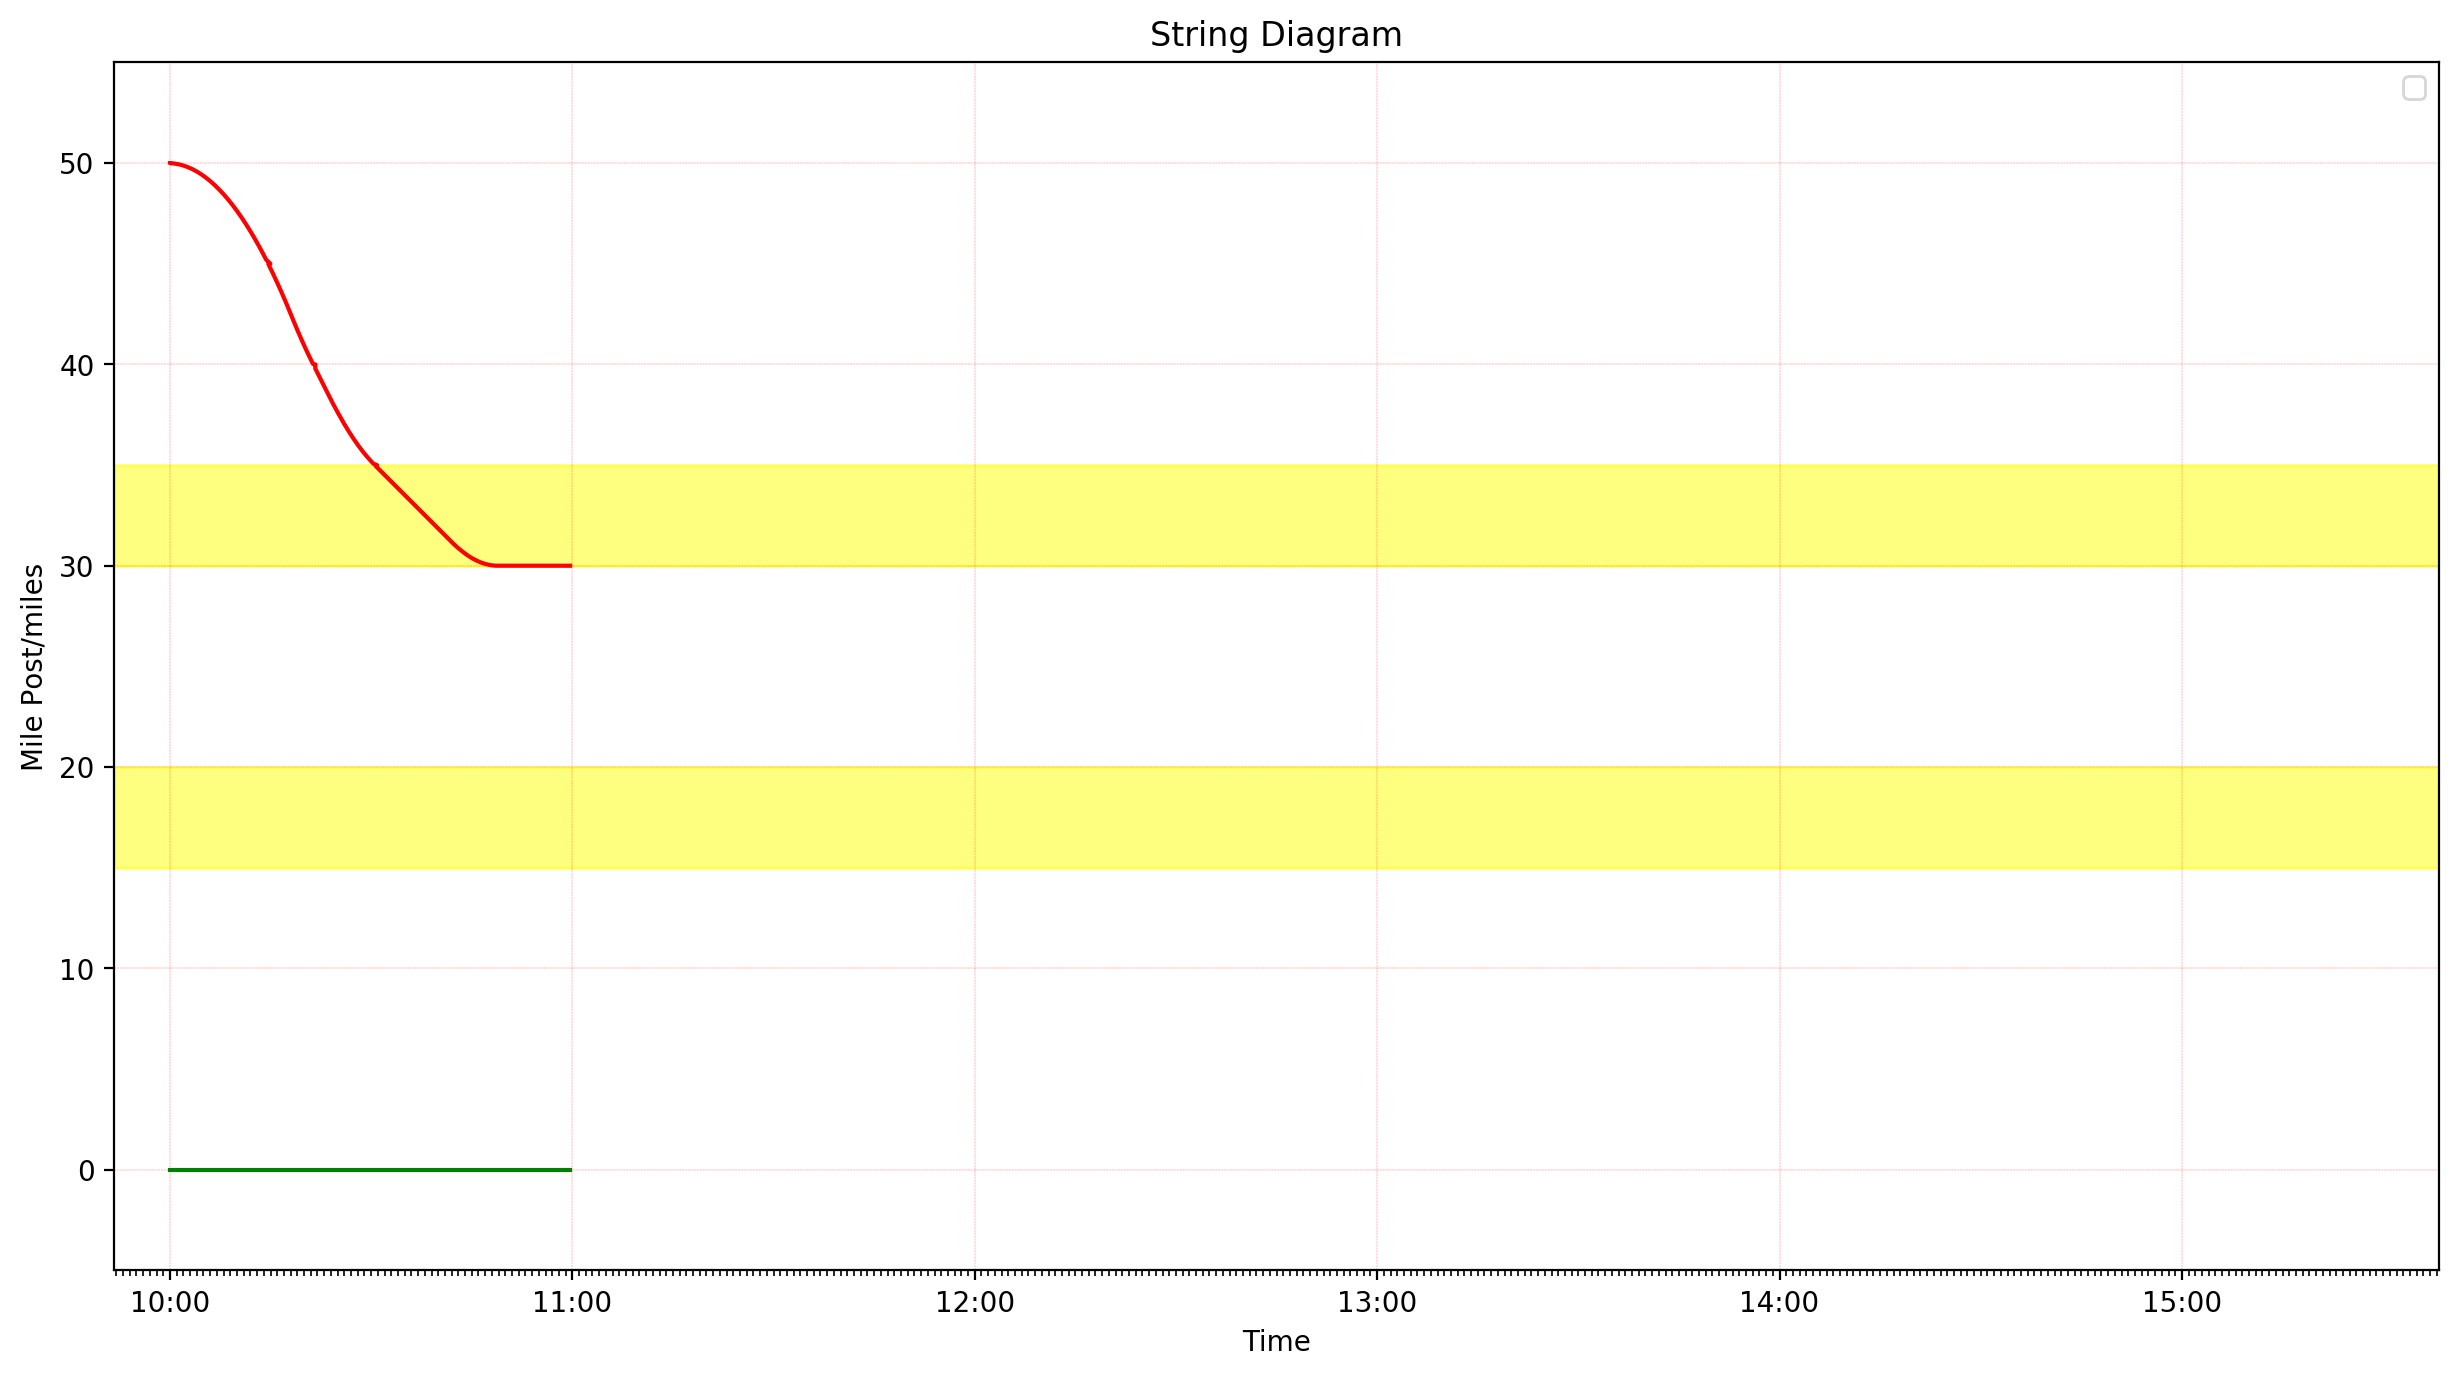

<Figure size 1440x1280 with 0 Axes>

In [19]:
from infrastructure import Track,BigBlock
from system import System
from train import Train
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
def string_diagram(sys, start_time, end_time):
    '''To draw the string diagram based on the schedule dictionary for all the trains. 
    '''
    colors = ['red','green','blue','black','orange','cyan','magenta']
    color_num = len(colors)
    x, y = [], []
    for i in range(len(sys.trains)):
        x.append([])
        y.append([])
        for j in range(len(sys.trains[i].time_pos_list)):
            x[i].append(datetime.fromtimestamp(sys.trains[i].time_pos_list[j][0]))
            y[i].append(sys.trains[i].time_pos_list[j][1])
            # x[i].append(sys.trains[i].time_pos_list[j][0])
            # y[i].append(sys.trains[i].time_pos_list[j][1])

    assert len(x) == len(y)
    for i in range(len(x)):
        assert len(x[i]) == len(y[i])
    train_idx = list(range(len(x)))
    t_color = [colors[x.index(i)%color_num] for i in x]
    min_t, max_t = min([i[0] for i in x if i]), max([i[-1] for i in x if i])
    
    #plt.ion()
    plt.title('String Diagram')
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator()
    seconds = mdates.SecondLocator()
    dateFmt = mdates.DateFormatter("%H:%M")
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_minor_locator(minutes)
    plt.gca().xaxis.set_major_formatter(dateFmt)
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Mile Post/miles')
    start_time = int(start_time.timestamp())
    end_time = int(end_time.timestamp())
    plt.axis([(datetime.fromtimestamp(start_time - 500)), \
            (datetime.fromtimestamp(end_time + 500)), -5 , 55])
    #===============================================================================
    # time_length = end_time - start_time
    # step_size = 10
    # for start in range(1,time_length + 1, step_size):
    #     plt.axis([(datetime.fromtimestamp(start_time - 500)), \
    #         (datetime.fromtimestamp(end_time + 500)), -5 , 55])
         
    #     for n in range(len(x)-1):
    #         new_x_y = [[mdates.date2num(datetime.fromtimestamp(i)), j] for i, j in zip(x[n], y[n]) if i < start_time + start and i > start_time + start - 1 - step_size]
    #         new_x = []
    #         new_y = []
    #         for i , j in new_x_y:
    #             new_x.append(i)
    #             new_y.append(j)
    #         if(len(new_x) == 0):
    #             continue
    #         plt.plot(new_x, new_y, color=t_color[n])
    #         # print('==============')
    #         # print('Length of new_x: {}'.format(len(new_x)))
    #         # print('Length of new_y: {}'.format(len(new_y)))
    #     plt.pause(0.00001)
    #===============================================================================
    for n in range(len(x)):
        #assert len(x[n]) == len(y[n]) == t_color[n]
        plt.plot([mdates.date2num(i) for i in x[n]], y[n], color=t_color[n])
    plt.gca().axhspan(15,20,color='yellow',alpha=0.5)
    plt.gca().axhspan(30,35,color='yellow',alpha=0.5)
#     plt.gca().axvspan((datetime.fromtimestamp(start_time + 90 * 60)),(datetime.fromtimestamp(start_time + 150 * 60)),color='black',alpha=0.5)
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.dpi'] = 200
    import pylab; pylab.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.show()
    #plt.ioff()
def speed_curve(sys, train):
    '''To draw the speed curve based on a train's mileposts and speed . 
    '''
    colors = ['red','green','purple']
    mp, spd, spdlmt, tgt_spd = [], [], [], []
    for i in range(len(train.pos_spd_list)):
        mp.append(train.pos_spd_list[i][0])
        spd.append(abs(train.pos_spd_list[i][1]*3600))
        spdlmt.append(train.pos_spd_list[i][2]*3600)
        tgt_spd.append(train.pos_spd_list[i][3]*3600)

    min_mp, max_mp = min(mp), max(mp)
    
    #plt.ion()
    plt.title('Speed Curve')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Mile Post/miles')
    plt.ylabel('MPH')
    plt.plot(mp, spd, color=colors[1])  # train speed
    plt.plot(mp, spdlmt, color=colors[0])  # train speed lmt
    plt.plot(mp, tgt_spd, color=colors[2])  # train tgt speed
    
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.dpi'] = 200
    import pylab; pylab.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.show()
    #plt.ioff()
string_diagram(sys, sim_init_time, sim_term_time)
# speed_curve(sys, T166)

In [8]:
print('MP:\t\t', T166.curr_MP)
print('curr_speed\t\t',T166.curr_speed * 3600)
print('curr_tgt_speed\t\t',T166.curr_target_spd_abs * 3600)
print('curr_spd_lmt\t\t',T166.curr_spd_lmt_abs * 3600)
print('\n')
print(T166.curr_acc*10)
T166.update_acc()
sys.sys_time+=sys.refresh_time

MP:		 39.93395509633637
curr_speed		 -37.35851716823617
curr_tgt_speed		 20.0
curr_spd_lmt		 40.0


4.981107672042101e-05


AssertionError: 

In [15]:
abs(T166.curr_speed**2-(20/3600)**2)/(2*4.981107672042101e-05/10)

7.7116908663800725

In [14]:
T166.curr_brake_distance_abs

7.7116908663800725